In [272]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit as fit
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd


import sys
import os

sns.set_context('notebook')
plt.rcParams['image.cmap'] = 'jet' #viridis' #'inferno'
%matplotlib notebook

In [273]:
# constants
h = 6.626e-34 # plancks constant, J/s
c = 2.99792458e8 # m/s
k = 1.381e-23 # boltzmann's constant, J/K

In [288]:
# parameters
photon_energy_keV = 9.5 # photon energy, keV
a = 4e-6 # beam size, m
L=1.5
pulse_energy = 0.03*60e-6 # 0.2e-3*0.015 # J (XPP, SnD transmission)

In [276]:
pix = 50e-6 # pixel size, m
d = 50e-6 # sample thickness, m

bandwidth=1e-4 
sigma=1 # random not used
R=1 # random not used

photon_energy = photon_energy_keV*1e3*1.602e-19 # photon energy, J
wavelength = h*c/photon_energy # wavelength, m
wavelength

1.305226904992444e-10

# q-range

### 2x2 epix100 for xsvs

In [379]:
Ldet = L            # SDD, m 
angle1 = 16.3          # detector angle 1, deg

# parameters from https://lcls.slac.stanford.edu/detectors/ePix100
dpix = 50e-6           # the physical size of the pixels, m
detector = 2*(384+352)*dpix  # detector width of 2x2 epix100: 2x2 units (each epix is 4x(384x352) pixels) (old: epix100: 388 x 370, 50 um pixels)

print('detector width:',detector*1e3, 'mm')

Ldet0 = dpix*a/wavelength   # detector to sample distance, m 
print('min sample-detector distance:',Ldet0, 'm')

L2 = np.sqrt((detector/2)**2+Ldet**2) # side of detector-sample triangle (two sides of equal lengths)
theta1 = angle1*np.pi/180 
theta2 = np.arccos((2*L2**2-detector**2)/(2*L2**2))+theta1
angle = (theta2-theta1)/2+theta1
print('detector center angle:',angle*180/np.pi)

theta = np.array([theta1, theta2])

q = 4*np.pi/wavelength*np.sin(theta/2)/1e10 # 1/Å
q_c = 4*np.pi/wavelength*np.sin(angle/2)/1e10 # 1/Å
print('q-range:', q,'1/Å')
print('center q:', q_c,'1/Å')
np.diff(q)

detector width: 73.6 mm
min sample-detector distance: 1.5323006232480154 m
detector center angle: 17.70537454493586
q-range: [1.36487629 1.59821012] 1/Å
center q: 1.4816546297978506 1/Å


array([0.23333384])

In [419]:
Ldet = 4.3            # SDD, m 
angle1 = -0.25         # detector angle 1, deg

# parameters from https://lcls.slac.stanford.edu/detectors/ePix100
dpix = 50e-6           # the physical size of the pixels, m
detector = (384+352)*dpix  # detector width of 2x2 epix100: 2x2 units (each epix is 4x(384x352) pixels) (old: epix100: 388 x 370, 50 um pixels)

print('detector width:',detector*1e3, 'mm')

Ldet0 = dpix*a/wavelength   # detector to sample distance, m 
print('min sample-detector distance:',Ldet0, 'm')

L2 = np.sqrt((detector/2)**2+Ldet**2) # side of detector-sample triangle (two sides of equal lengths)
theta1 = angle1*np.pi/180 
theta2 = np.arccos((2*L2**2-detector**2)/(2*L2**2))+theta1
angle = (theta2-theta1)/2+theta1
print('detector center angle:',angle*180/np.pi)

theta = np.array([theta1, theta2])

q = 4*np.pi/wavelength*np.sin(theta/2)/1e10 # 1/Å
q_c = 4*np.pi/wavelength*np.sin(angle/2)/1e10 # 1/Å
print('q-range:', q,'1/Å')
#print('center q:', q_c,'1/Å')

detector width: 36.8 mm
min sample-detector distance: 1.5323006232480154 m
detector center angle: -0.004828858473350079
q-range: [-0.02100443  0.02019301] 1/Å


### jungfrau1M for static waxs

In [383]:
# estimation for a tilted jungfrau detector (i.e. not perpendicular)

Ldet = 0.2 # SDD, m 
angle1 = 12 # deg

dpix = 75e-6 # m
detector = 1024*dpix # width, jungfrau 1M (dim: 1024x1024)

# detector-sample geometries
print('detector width:',detector*1e3, 'mm')

L2 = np.sqrt((detector/2)**2+Ldet**2) # side of detector-sample triangle (two sides of equal lengths)
theta1 = angle1*np.pi/180 
theta2 = np.arccos((2*L2**2-detector**2)/(2*L2**2))+theta1
angle = (theta2-theta1)/2+theta1
print('detector center angle:',angle*180/np.pi)

theta = np.array([theta1, theta2])

q = 4*np.pi/wavelength*np.sin(theta/2)/1e10 # 1/Å
q_c = 4*np.pi/wavelength*np.sin(angle/2)/1e10 # 1/Å
print('q-range:', q,'1/Å')

detector width: 76.8 mm
detector center angle: 22.868525340168706
q-range: [1.00637169 2.79374099] 1/Å


#### new estimation from setup

In [314]:
# perpendicular jungfrau detector position

theta1=np.arccos(0.183/0.199) #lowest angle -- update because the position not correct (will be moved in!)
print(theta1*180/np.pi,'deg')
q=4*np.pi/wavelength*np.sin(theta1/2)*1e-10
print(q)

23.132618604732034 deg
1.9303777443545185


# Contrast

In [281]:
from scipy import integrate

def beta_cl(a, d, bandwidth, wavelength, qval, R, sigma):
    k = 2*np.pi/wavelength
    etah = 100e-6 # for fully coherent beam, coh len >> beam size
    #etah = R*wavelength/(2*np.pi*sigma) # estimated coherence from source size (sigma) and distance from the source (R)
    A = bandwidth * qval * np.sqrt(1 - 0.25 * qval**2 / k**2)
    B = - bandwidth/2 * qval**2 / k
    f1 = lambda x, z:  (a-x)*(d-z)*(np.exp(-x**2/etah**2-2*np.absolute(bandwidth*qval*np.sqrt(1-0.25*(qval/k)**2)*x-bandwidth/2*qval**2*z/k))+np.exp(-x**2/etah**2-2*np.absolute(bandwidth*qval*np.sqrt(1-0.25*(qval/k)**2)*x+bandwidth/2*qval**2*z/k)))
    out = integrate.dblquad(f1, 0, d, lambda x: 0, lambda z: a)
    return 2/(a*d)**2 * out[0]

def beta_res(a, L, pix, wavelength):
    w = 2*np.pi*pix*a/(L*wavelength)
    f2 = lambda v: 2/w**2 * (w-v) * (np.sin(v/2)/(v/2))**2
    out = integrate.quad(f2, 0, w)
    return np.array(out[0]**2)

def speckle_contrast(a, d, L, pix, wavelength, bandwidth, qval, R, sigma):
    coherence = 1.
    beta = beta_res(a, L, pix, wavelength) * beta_cl(a, d, bandwidth, wavelength, qval, R, sigma) * coherence
    return beta


### contrast vs q

<IPython.core.display.Javascript object>


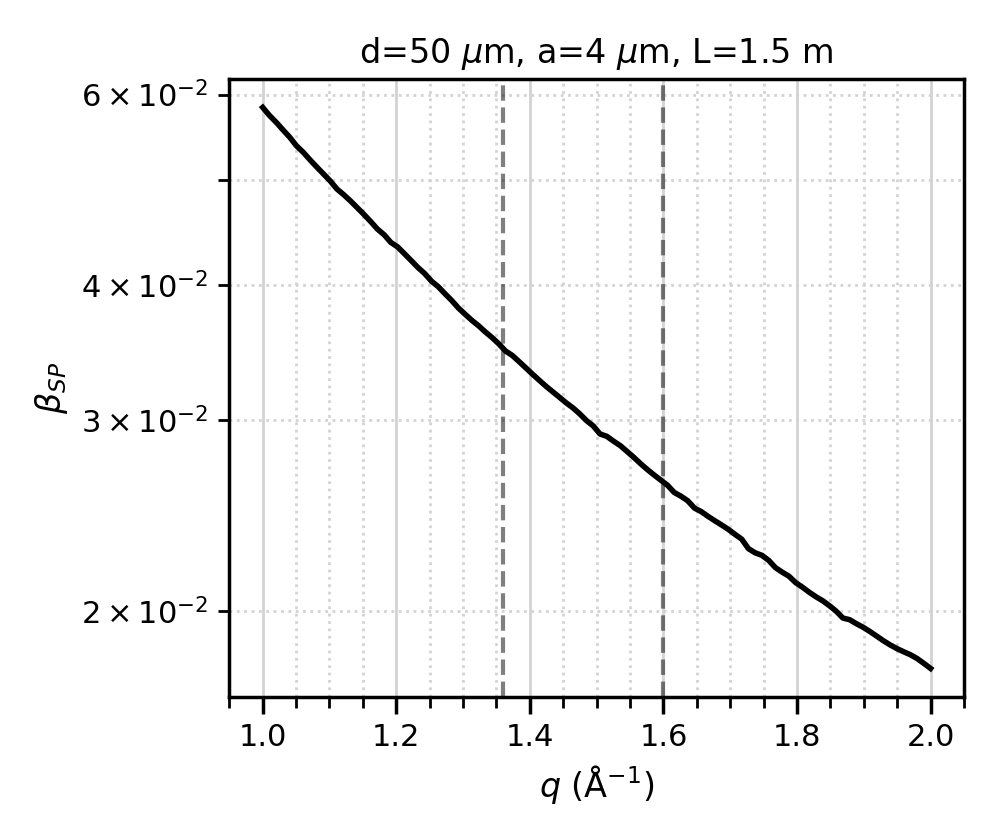

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [399]:
plt.figure(figsize=(5,4.2), tight_layout=True)

q = np.linspace(1., 2, 100) # 1/Å
    
contrast = np.empty((len(q),))
for j in range(len(q)):
    contrast[j] = speckle_contrast(a, d, L, pix, wavelength, bandwidth, q[j]*1e10, R, sigma)

l, = plt.plot(q, contrast,'k-', lw=2) #, label=r'a=%.d $\mu$m, L=%.1f m' %((a*1e6, L)))

plt.axvline(x=1.36,linestyle='--',c='k',alpha=0.5, lw=1.5)
plt.axvline(x=1.6,linestyle='--',c='k',alpha=0.5, lw=1.5)
#plt.axvline(x=2.0,linestyle='--',c='k',alpha=0.5, lw=1.5)
    
plt.tick_params()
plt.xlabel(r'$q$ (Å$^{-1}$)')
plt.ylabel(r'$\beta_{SP}$')
plt.minorticks_on()
plt.grid(which='major',color='lightgrey')
plt.grid(which='minor',linestyle=':', color='lightgrey')
#plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-2,1e-1])
plt.legend(frameon=False)
plt.title('d=%.d $\mu$m, a=%.d $\mu$m, L=%.1f m' %(d*1e6,a*1e6, L))
plt.savefig('estimate_contrast.png', dpi=300, bbox_inches='tight')# save plot

plt.show()

### contrast vs sample-detector distance

<IPython.core.display.Javascript object>


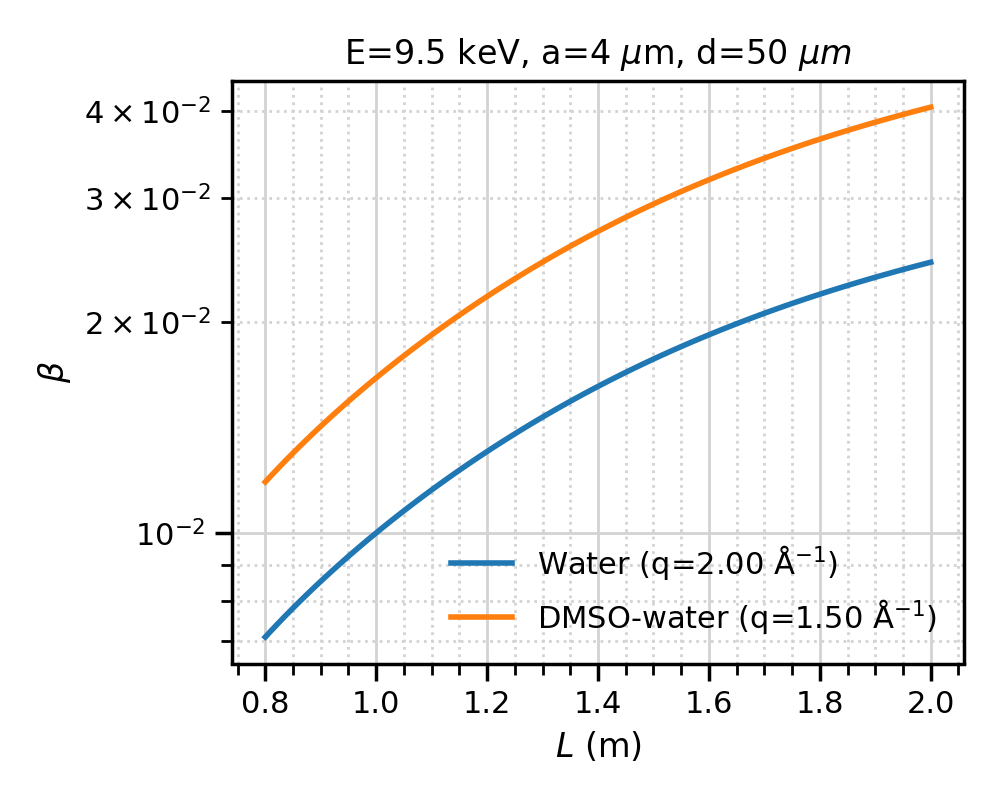

In [386]:
#plt.figure(figsize=(8,6))
fig, axs = plt.subplots(1,1,figsize=(5,4), tight_layout=True)

Ls = np.linspace(0.8, 2., 100) # m
#qs=np.array([2.0, 1.48, 1.42, 1.45]) # Å-1
qs=np.array([2.0, 1.5]) # Å-1
samples = ['Water','DMSO-water'] #'$x_{DMSO}=0.33$','$x_{DMSO}=0.67$', '$x_{DMSO}=1.0$']
   
for ii in range(1):
    i=0
    for q in qs:
        contrast = np.empty((len(Ls),))
        contrast2 = np.empty((len(Ls),))
        for j in range(len(Ls)):
            contrast[j] = speckle_contrast(a, d*(ii+1), Ls[j], pix, wavelength, bandwidth, q*1e10, R, sigma)
            #contrast2[j] = speckle_contrast(a, d, L[j], pix, wavelength, bandwidth, q*1e10, R, sigma)

        l, = axs.plot(Ls, contrast,'-', lw=2, label=r'%s (q=%.2f Å$^{-1}$)' %(samples[i], q))
        #l2, = axs[ii].plot(L, contrast2,':', color=l.get_color(), lw=2, label=r'%s (q=%.2f Å$^{-1}$) %.d $\mu m$' %((samples[i], q , d*1e6)))
        i+=1

    #plt.axvline(x=1.2,linestyle='--',c='k',alpha=0.5, lw=1.5)

    axs.tick_params()
    axs.set_xlabel(r'$L$ (m)')
    axs.set_ylabel(r'$\beta$')
    axs.minorticks_on()
    axs.grid(which='major',color='lightgrey')
    axs.grid(which='minor',linestyle=':', color='lightgrey')
    #plt.xscale('log')
    axs.set_yscale('log')
    #plt.ylim([1e-2,1e-1])
    axs.legend(frameon=False)
    axs.set_title('E=%.1f keV, a=%.d $\mu$m, d=%.d $\mu m$' %(photon_energy_keV, a*1e6, d*(ii+1)*1e6))
    
plt.savefig('contrast_vs_distance',dpi=300)
plt.show()

# Intensity

In [387]:
def intensity_out(I_in, w=100, pixs=50, d=1.):
    """Calculates the scattered intensity from water droplets.

    Args:
        I_in (float): the initial intensity.
        w (float, optional): the sample (water droplet) thickness in micro meters (um).
        pixs (float, optional): the pixel size in um.
        d (float, optional): sample to detector distance in meters (m).

    Returns: 
        I_out (float): the scattered intensity per pixel in photons.

    """
    # rescaling the input parameters
    w = w * 1e-6 # sample thickness in m
    pixs = pixs * 1e-6 # pixel size in m

    ### START CODE HERE ###
    delta_omega_pix = pixs**2/d**2  # solid angle covered by one pixel 
    
    mcs_water = 16.32  # macroscopic scattering cross-section of water at 2Å in 1/m
    
    I_out = I_in*mcs_water*delta_omega_pix*w  # scattered intensity in photons

    return I_out


1.1827321111768183 10^9 photons/pulse


<IPython.core.display.Javascript object>


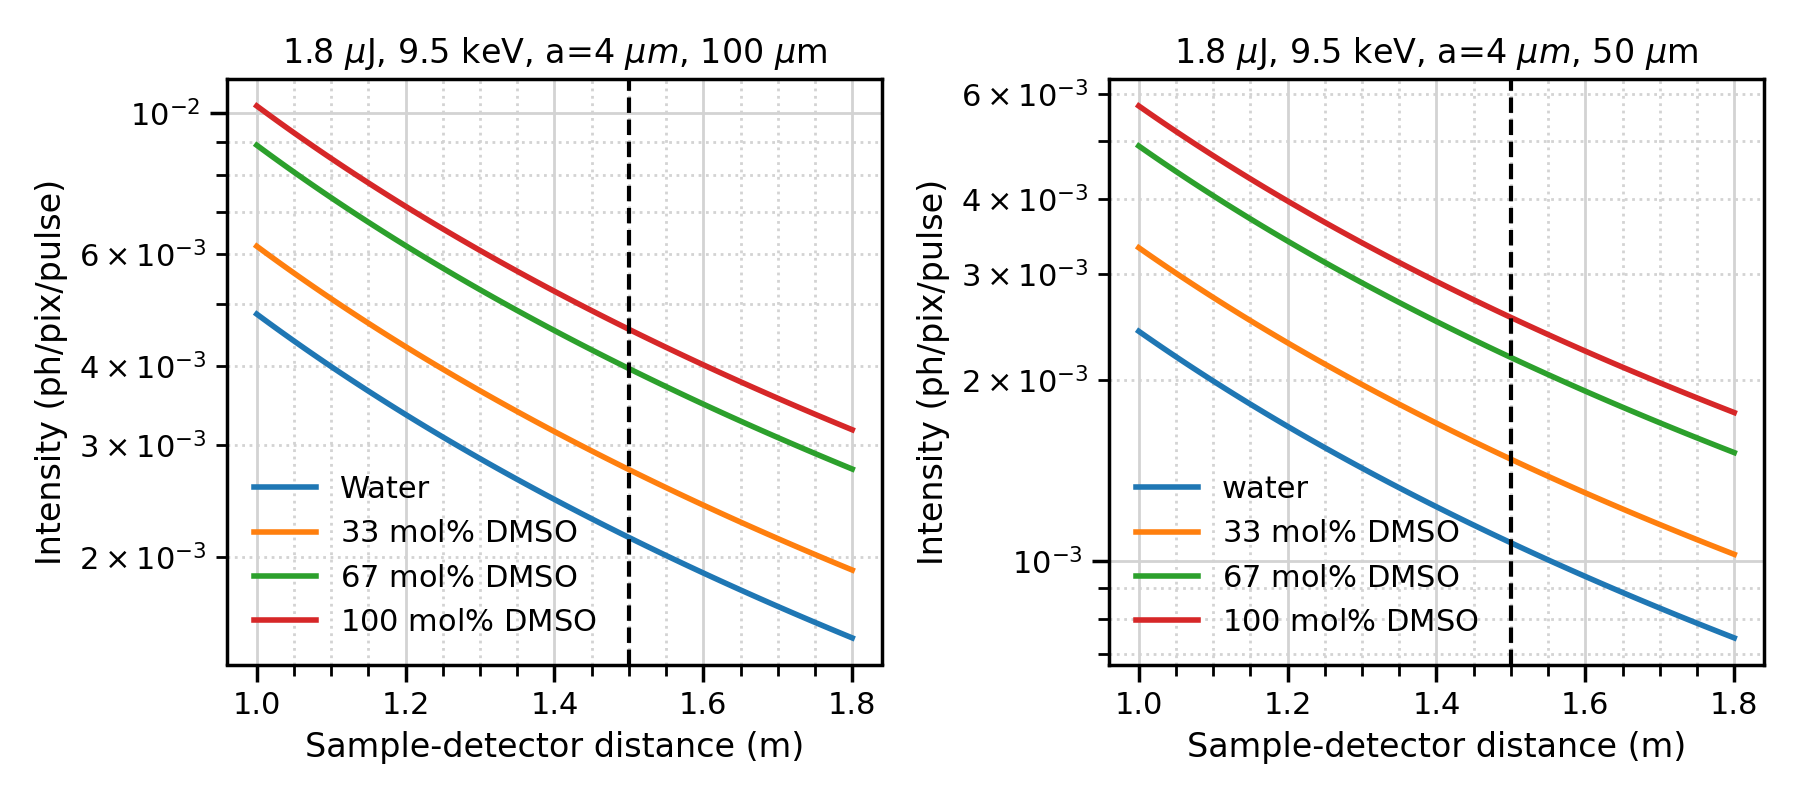

In [388]:
################### BEAM ######################

I_in = pulse_energy/photon_energy # ph/pulse estimation using 1.5% SND transmission
print(I_in/1e9, '10^9 photons/pulse')

############## SAMPLE ########################

thickness1 = 100 # um sample thickness
thickness2 = 50 # um sample thickness

thickness=[thickness1, thickness2]

#1. 1.37769487 2.03487317 2.37239976 # 50 um based on Mo data
#1. 1.27936736 1.84614691 2.12908309 # 100 um

scatt_ratio_33dmso1 = 1.27936736 # scattering intensity relative water at 9.5 keV
scatt_ratio_33dmso2 = 1.37769487 # scattering intensity relative water at 9.5 keV

scatt_ratio_67dmso1 = 1.8461469 # scattering intensity relative water at 9.5 keV
scatt_ratio_67dmso2 = 2.03487317 # scattering intensity relative water at 9.5 keV

scatt_ratio_dmso1 = 2.12908309 # scattering intensity relative water at 9.5 keV
scatt_ratio_dmso2 = 2.37239976 # scattering intensity relative water at 9.5 keV

########################################
# speckle size
Lmatch = pix*a/wavelength
#ax.axvline(x=Lmatch, color='grey', linestyle='--', alpha =1., label=r'matching speckle size (a=%.d $\mu$m)' %(a*1e6))

threshold = 0.01  # the lower intensity threshold
distances = np.linspace(1, 1.8, 100)  # the detector distances in m


# the scattered intensity per pixel
I_out_wat1 = intensity_out(I_in, w=thickness1, pixs=50, d=distances)
I_out_wat2 = intensity_out(I_in, w=thickness2, pixs=50, d=distances)

I_out_33dmso1 = intensity_out(I_in, w=thickness1, pixs=50, d=distances)*scatt_ratio_33dmso1
I_out_33dmso2 = intensity_out(I_in, w=thickness2, pixs=50, d=distances)*scatt_ratio_33dmso2

I_out_67dmso1 = intensity_out(I_in, w=thickness1, pixs=50, d=distances)*scatt_ratio_67dmso1
I_out_67dmso2 = intensity_out(I_in, w=thickness2, pixs=50, d=distances)*scatt_ratio_67dmso2

I_out_dmso1 = intensity_out(I_in, w=thickness1, pixs=50, d=distances)*scatt_ratio_dmso1
I_out_dmso2 = intensity_out(I_in, w=thickness2, pixs=50, d=distances)*scatt_ratio_dmso2


# creating the figure and axes
fig, ax = plt.subplots(1,2,figsize=(9.,4.), tight_layout=True)

# plot the data
l1, = ax[0].plot(distances, I_out_wat1, '-', linewidth=2, label=r'Water')
l2, = ax[1].plot(distances, I_out_wat2, '-', linewidth=2, color=l1.get_color(), label=r'water')

l3, = ax[0].plot(distances, I_out_33dmso1, '-', linewidth=2, label=r'$33$ mol% DMSO')
l4, = ax[1].plot(distances, I_out_33dmso2, '-', linewidth=2, color=l3.get_color(), label=r'$33$ mol% DMSO')

l5, = ax[0].plot(distances, I_out_67dmso1, '-', linewidth=2, label=r'$67$ mol% DMSO')
l6, = ax[1].plot(distances, I_out_67dmso2, '-', linewidth=2, color=l5.get_color(), label=r'$67$ mol% DMSO' )

l7, = ax[0].plot(distances, I_out_dmso1, '-', linewidth=2, label=r'$100$ mol% DMSO')
l8, = ax[1].plot(distances, I_out_dmso2, '-', linewidth=2, color=l7.get_color(), label=r'$100$ mol% DMSO')

for i in range(2):
   # ax[i].hlines(threshold, distances.min(), distances.max(), color='k', linestyle='--', alpha = 1.)
    ax[i].axvline(x=1.5, color='k', linestyle='--', alpha = 1.)

    # setting up the axes style
    ax[i].minorticks_on()
    ax[i].grid(which='major',color='lightgrey')
    ax[i].grid(which='minor',linestyle=':', color='lightgrey')
    ax[i].set_ylabel("Intensity (ph/pix/pulse)")
    ax[i].set_xlabel("Sample-detector distance (m)")
    ax[i].set_yscale('log')
    ax[i].legend(frameon=False, loc='lower left') #, borderpad=1)
    ax[i].set_title(r'$%.1f$ $\mu$J, %.1f keV, a=%.f $\mu m$, %.d $\mu$m' %(pulse_energy*1e6, photon_energy_keV, a*1e6, thickness[i]))
   # ax[i].set_ylim([5e-4,2e-2])
#plt.tick_params()
plt.tight_layout

plt.savefig('estimate_I_distance.png', dpi=300, bbox_inches='tight')# save plot

plt.show()


# signal to noise

In [389]:
# the scattered intensity per pixel
I_out_33dmso = intensity_out(I_in, w=thickness2, pixs=50, d=1.5)*scatt_ratio_33dmso2
I_out_67dmso = intensity_out(I_in, w=thickness2, pixs=50, d=1.5)*scatt_ratio_67dmso2
I_out_dmso = intensity_out(I_in, w=thickness2, pixs=50, d=1.5)*scatt_ratio_dmso2

kbar=np.array([I_out_33dmso, I_out_67dmso, I_out_dmso])
kbar

array([0.00147736, 0.00218208, 0.00254403])

In [390]:
def sn(N, beta, k_bar, n_pix):  
    return (k_bar*beta)*1/np.sqrt(2*(1+beta)/(n_pix*N))


In [391]:
# parameters to modify based on intensity and contrast estimations above:
k_bar = 2e-3 # ph/pix/pulse
beta1 = 0.03 # contrast

beta2 = beta1/2 # contrast
n_pix = 4*352*384 # no of pixels (4 x epix100)

<IPython.core.display.Javascript object>


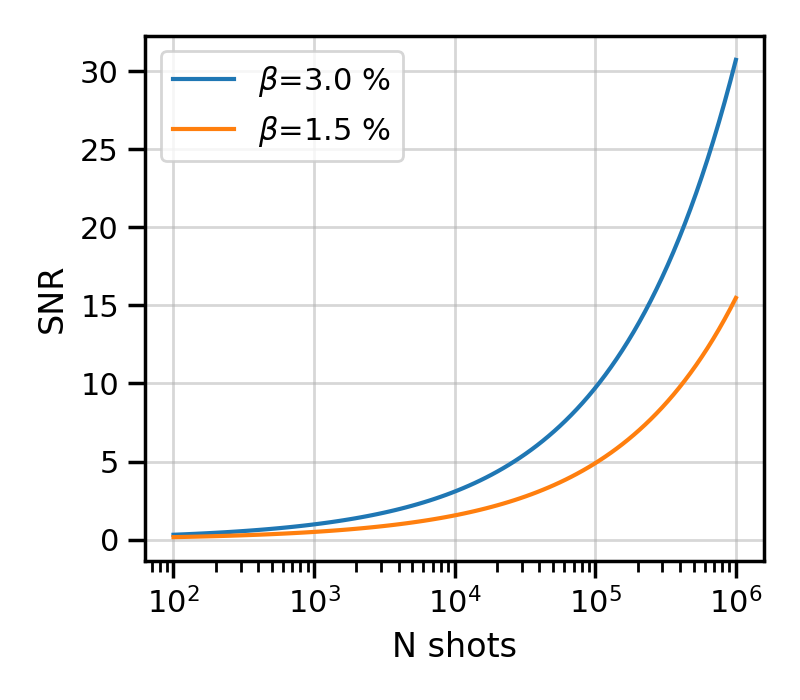

In [392]:
N = np.logspace(2,6,100)

plt.figure(figsize=(4,3.5), tight_layout=True)
plt.plot(N,sn(N, beta1, k_bar, n_pix),'-', label=r'$\beta$=%.1f %%' %(beta1*100))
plt.plot(N,sn(N, beta2, k_bar, n_pix),'-', label=r'$\beta$=%.1f %%' %(beta2*100))
plt.xscale('log')
plt.xlabel('N shots')
plt.ylabel('SNR')
#plt.xlim([1e3,1e6])
#plt.ylim([0,15])
plt.legend()
plt.grid(True, alpha=0.5)

plt.savefig('snr_shots',dpi=300)
plt.show()

In [393]:
# parameters to modify
nshots0 = 10e5 # no. of shots for the first delay
ts = np.logspace(np.log10(0.4),np.log10(10),5) # delays, ps
nshots = nshots0*np.ones(len(ts)) #np.arange(1,len(ts)+1) # no of shots for each delay
r=1 # split ratio, here: I1/I2
rep_rate = 120 # Hz

time_per_delay = shots/(rep_rate)
print('Time per delay:',np.round(time_per_delay/60,1),'min') # min

Time per delay: 138.9 min


[ 0.4         0.89442719  2.          4.47213595 10.        ]


<IPython.core.display.Javascript object>


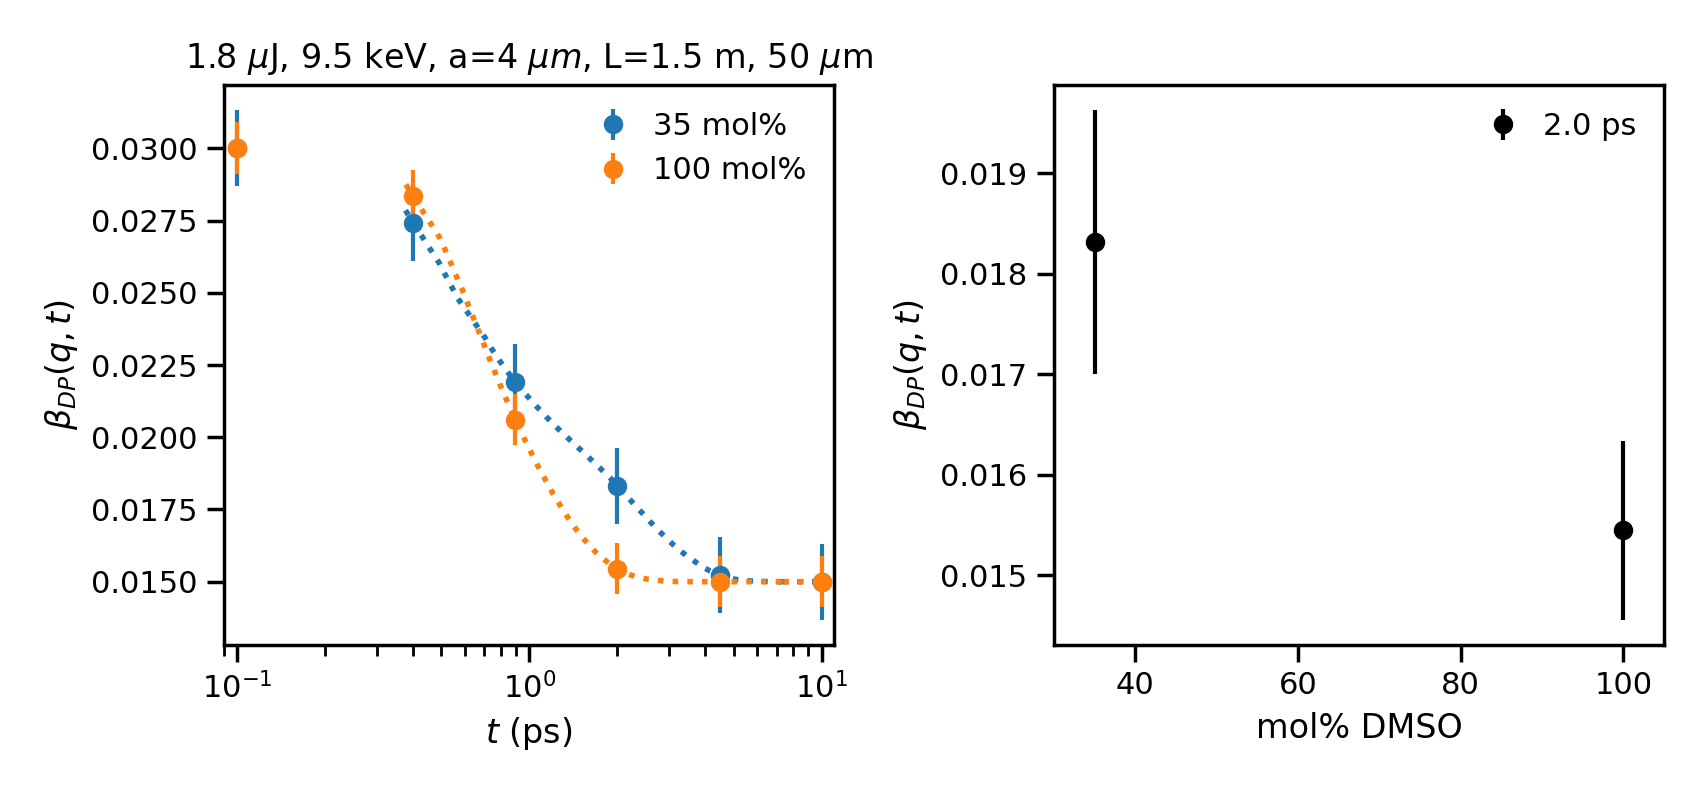

In [394]:
print(ts)

fig, ax = plt.subplots(1,2,figsize=(8.5,4))

v=[0,1,1,2]
#cols=['k','r','b','g','y','m']
cols = plt.cm.coolwarm(np.linspace(0.05,0.95,6)) 
for i, mol in enumerate([35,100]):
    
    data = np.loadtxt(f'{mol}mol_dmso_Fq.txt')
    t = np.append(np.exp(data[:,0]), np.linspace(7,10,5)) # ps
    g1 = np.append(data[:,1], np.zeros(5))
    
    contrast = beta1 * (r**2 + 1 + 2*r*g1**2)/(r**2 + 1 + 2*r)
    contrast0 = beta1 * (r**2 + 1 + 2*r*1**2)/(r**2 + 1 + 2*r)
    f_contrast = interp1d(t, contrast,kind='cubic')
    
    snr=np.empty(len(ts))
    for j in range(len(ts)):
        snr[j] = sn(nshots[j], f_contrast(ts[j]), kbar[v[i]], n_pix)
    snr0 = sn(nshots0, contrast0, kbar[v[i]], n_pix)
    
    l, = ax[0].plot(t, contrast,':',lw=2)
    ax[0].errorbar(ts, f_contrast(ts),yerr=f_contrast(ts)/snr, fmt='o', color=l.get_color(), label=r'%.f mol%%' %(mol))
    ax[0].errorbar(0.1, contrast0, yerr=contrast0/snr0, fmt='o', color=l.get_color())
    
    #for j in range(len(ts)):
    j=2
    if i==0:
        ax[1].errorbar(mol, f_contrast(ts[j]), yerr=f_contrast(ts[j])/snr[j], fmt='o', color='k', label=r'%.1f ps'%(ts[j]))
    else:
        ax[1].errorbar(mol, f_contrast(ts[j]), yerr=f_contrast(ts[j])/snr[j], fmt='o', color='k')
    
#plt.axvline(x=800,linestyle='--',c='k',alpha=0.5, lw=1.5)

ax[0].set_xscale('log')
ax[0].set_xlabel(r'$t$ (ps)')
ax[0].set_ylabel(r'$\beta_{DP}(q,t)$')
ax[0].legend(frameon=False, handlelength=1.)
ax[0].set_xlim(0.09,11)
ax[0].set_title(r'$%.1f$ $\mu$J, %.1f keV, a=%.f $\mu m$, L=%.1f m, %.d $\mu$m' %(pulse_energy*1e6, photon_energy_keV, a*1e6, L, thickness[i]))

ax[1].set_xlabel(r'mol% DMSO')
ax[1].set_ylabel(r'$\beta_{DP}(q,t)$')
ax[1].legend(frameon=False, handlelength=1.)
ax[1].set_xlim(30,105)
#ax[1].set_ylim(0.022,0.032)

plt.tight_layout()
plt.savefig('contrast_conc',dpi=300)
plt.show()

In [398]:
print('delays (ps):', np.append(0.1,ts))
print('aquisition time (min):', np.append(nshots0,nshots)/120/60)
print('total aq. time (hrs):', np.sum(np.append(nshots0,nshots)/120/3600))

delays (ps): [ 0.1         0.4         0.89442719  2.          4.47213595 10.        ]
aquisition time (min): [138.88888889 138.88888889 138.88888889 138.88888889 138.88888889
 138.88888889]
total aq. time (hrs): 13.88888888888889


## continous jet sample consumption

In [396]:
D = 50 # um, jet diameter
time = 12*3600*5 # s - 1 shift=12 hrs
velocity = 10 # m/s

R = D*1e-6/2 # jet radius, m
area = np.pi*R**2 # m^2
print(time, area)

#volume = area*9.82*(time**2)/2 # only gravity, m^3
vol = area*velocity*time # set velocity

print('total volume (L):', vol*1000) # litres 
print('approx. cryo volume 33mol% (L):',vol*1000*0.66) # cryo, litres 
print('approx. cryo volume 67mol% (L):',vol*1000*0.89) # cryo, litres 
print('approx. cryo volume 100mol% (L):',vol*1000*1.0) # cryo, litres 
print('hours per volume (h/L):', (12*5)/(vol*1000) ) # litres 

216000 1.9634954084936203e-09
total volume (L): 4.24115008234622
approx. cryo volume 33mol% (L): 2.799159054348505
approx. cryo volume 67mol% (L): 3.7746235732881357
approx. cryo volume 100mol% (L): 4.24115008234622
hours per volume (h/L): 14.147106052612923


# Form factor

In [400]:
def F_sphere(q, R): 
    """Formfactor of a sphere of radius R.
    
    Args:
        q (np.ndarray): momentum transfer.
        R (float): radius of particles.
    
    Returns:
        np.ndarray: the formfactor for each q.
    """
    Vp = 4/3*np.pi*R**3
    f = Vp * 3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3  
    return f**2

<IPython.core.display.Javascript object>


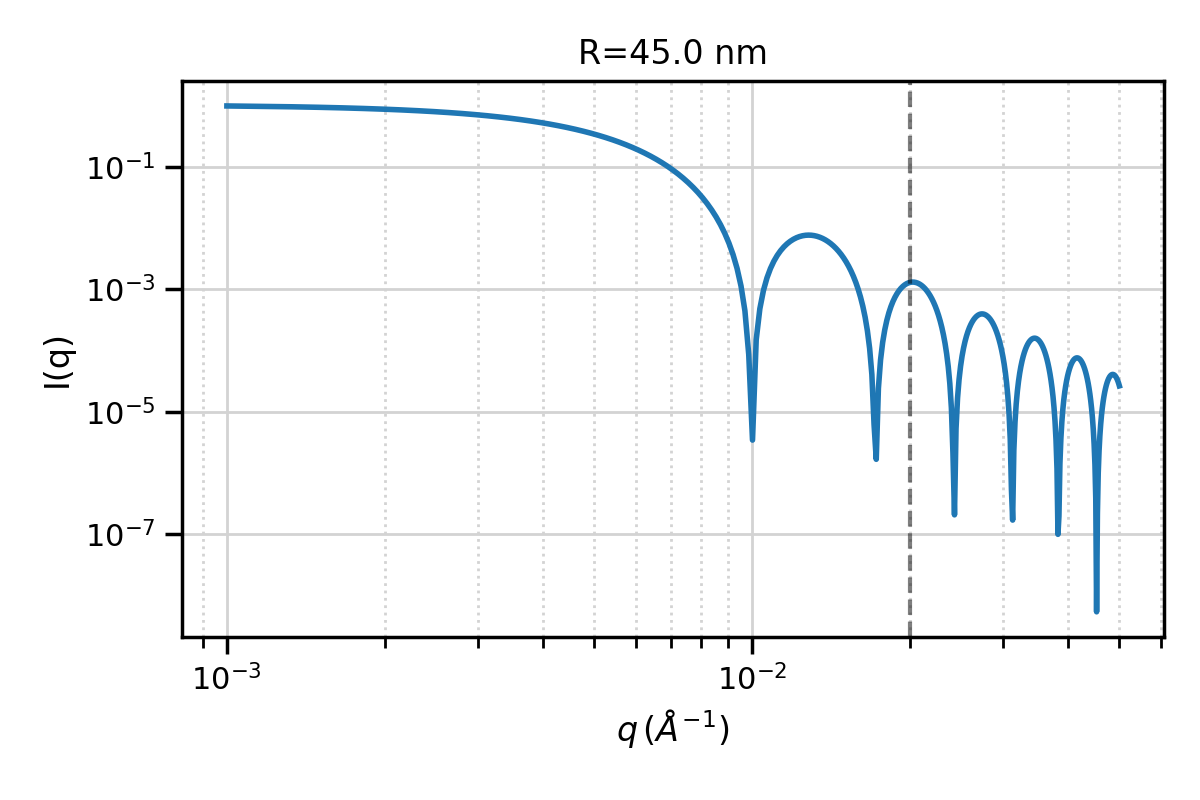

In [422]:
from jscatter.formel import schulzDistribution
from jscatter.formel import pDA
from jscatter.formfactor import sphere

q = np.linspace(0.001,0.05,300) # 1/Å
R = 90/2*10 # Å  
#sigmas = 0.01*R  
#Vp = 4/3*np.pi*(R*1e-9)**3

fig = plt.figure(figsize=[6,4])
#for sigma in sigmas:
f = F_sphere(q, R)
#f = pDA(sphere, sigma, 'radius', type='Schulz', q=q, radius=R).Y
plt.plot(q, f/f[0], '-', lw=2)
    
plt.axvline(x=0.02,linestyle='--',c='k',alpha=0.5, lw=1.5)
    
plt.ylabel('I(q)')
plt.xlabel('$q\,(\AA^{-1})$')
plt.yscale('log')
plt.xscale('log')
#plt.ylim([1e-3,1.1])
plt.title('R=%.1f nm' %(R/10))
plt.minorticks_on()
plt.grid(which='major',color='lightgrey')
plt.grid(which='minor',linestyle=':', color='lightgrey')
#plt.grid(True, which='major', axis='both')
#plt.grid(True, which='minor', axis='both', linestyle=':')
#plt.legend(loc='lower left', title=r'$\sigma / R (\%)$', frameon=False, prop={'size': 14});
plt.tight_layout()
plt.show()